# Image Classification Using MLP


In this notebook, we will explore the process of classifying handwritten digits from the MNIST database. We will cover concepts related to the broader problem of classification, specifically when dealing with multiple classes. This type of classification is often referred to as multinomial regression or softmax regression or simply multi-class classification when there are more than two classes involved.

The MNIST dataset is readily available in `torchvision` and can be easily imported and loaded, as we will demonstrate below. By utilizing this dataset, we will showcase how to effectively handle image data representing digits ranging from 0 to 9. Additionally, we will develop a network architecture consisting of ten outputs neurons, one for each digit.

<img src='https://opencv.org/wp-content/uploads/2023/05/c2_w1_01_cover_MNIST_Digits.png' width=650 align='center'>

## Table of Contents

*   [1 Mathematical Foundation](#1-Mathematical-Foundation)
*   [2 Installation & Imports](#2-Installation-&-Imports)
*   [3 Training & Dataset Configurations](#3-Training-&-Dataset-Configurations)
*   [4 MNIST Data Loading and Preparation](#4-MNIST-Data-Loading-and-Preparation)
*   [5 Training and Evaluation Helper functions](#5-Training-and-Evaluation-Helper-functions)
*   [6 Main function for Training](#6-Main-function-for-Training)
*   [7 Model Architecture](#7-Model-Architecture)
*   [8 Multi Layer Perceptron](#8-Multi-Layer-Perceptron)
*   [9 Model Evaluation](#9-Model-Evaluation)
*   [10 Conclusion](#10-Conclusion)

</div>

## 1 Mathematical Foundation

### 1.1 Binary Classification & Binary Cross-Entropy


In a **classification** problem, the predicted output is a categorical label that specifies which class the input sample belongs to.

In a binary classification problem, the data instances are divided in two classes for e.g., determine whether a tumor is benign or malignant. The classes are labeled as "benign" (0) and "malignant" (1). Our objective is to build a model that predicts the correct class based on these features available in the dataset. Instead of predicting a numerical value like in regression, our goal is to assign the correct class label.

But how do we accomplish this? This is where the **logistic function** comes to the rescue as defined below:

$$ z = \sum_{i=0}^{n} \theta_ix_i = \theta^Tx $$

$$ y' = \sigma(z) = \frac{1}{1 + e^{-z}} = \frac{1}{1 + e^{-(\theta^Tx)}}$$

Using this function, we can now transform our weighted inputs to produce a real-valued number bounded between 0 and 1 (where 0 represents one class and 1 represents the other class). In a binary classifcation problem, these two classes are sometimes referred to as the negative and positive classes, respectively.

As an exercise, take 100 values between -10 and +10 for `z` and pass it through the function. Gather the outputs and do a scatter plot of the inputs and outputs.  This function is also commonly referred to as a **sigmoid** function because the shape resembles an 'S' curve.

---

**Binary cross-entropy loss** function is a commonly used loss function in binary classification tasks, where the goal is to assign each input to one of two possible classes. It measures the dissimilarity between the predicted probability distribution and the true probability distribution of the classes. The binary cross-entropy loss is calculated by taking the negative logarithm of the predicted probability for the correct class. In other words, it penalizes the model more when it confidently predicts the wrong class and less when it predicts the correct class with high confidence.

Mathematically, let's denote the predicted probability for the positive class as `y'` and the true label as `y`. By minimizing this loss function, the model learns to adjust its parameters to make accurate predictions and assign higher probabilities to the correct class.


$$J(y') = - y\ log(y')\ -\  (1-y)\ log(1 - y')$$

---

Here is a small diagrammatical representation of a binary classification model with 2 input features:

<img src='https://opencv.org/wp-content/uploads/2023/05/c2_w1_01_binary_classification_block_diagram.webp' width=700 align='center'><br/>


In order to extend this to three or more classes, we are going to introduce the **softmax** activation function in the next section.

### 1.2 Softmax Activation Function

The softmax activation function is widely used in multi-class classification tasks, aiming to assign inputs to one of several classes. It is typically applied to the output layer of the network. The softmax function maps the inputs to a probability distribution, where the output of each neuron falls within the range of $(0, 1)$, and the sum of all outputs equals 1. For a given neuron with input $z_i = w_i^Tx + b_i$, the softmax function is defined as follows, considering there are $k$ possible classes:

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}$$

In this equation, $e$ represents the base of the natural logarithm, $w_i$ denotes the weights, $x$ represents the input vector, $b_i$ represents the bias term, and the denominator sums up the exponentiated values of all neurons in the output layer.

The function is differentiable, enabling the use of gradient-based optimization techniques during the training process.

### 1.3 Cross Entropy Loss Function

The loss function used for multi-class classification is known as the **Cross Entropy Loss** function and is defined with the same motivation as binary cross entropy loss. Here, we want to maximize the probability that a given input corresponds to a given class $i$ which is the same as minimizing the negative log of the probability. The loss function for a single example $x$ is the sum of the logs of the $k$ output classes:

$$ J(y') = -\sum_{i=1}^{k} 1\{y=i\}\ log\ [ y'_i ]$$

In the equation above, we make use of the indicator function $1\{y=i\}$ which evaluates to 1 if the condition in the brackets is true and to 0 otherwise. So, the total loss is a summation across each of the output neurons.

To understand why this makes sense, let's consider two cases. First, when the neuron with the highest output corresponds to the ground truth label, the total loss would be the negative logarithm of a high probability. For instance, if the probability is 0.9, the total loss would be $-log(0.9) = .105$. In contrast, if the correct class has a predicted probability of 0.01, the total loss would be the negative logarithm of a low probability, $-log(0.01) = 4.61$.

---

**Note:** To address numerical underflow and overflow issues with large or small numbers in calculations, PyTorch by default uses the the ***logsumexp trick*** primarily for computing the softmax function within the cross-entropy function. Implementation-wise, both `torch.nn.CrossEntropyLoss` class and `torch.nn.functional.cross_entropy` function accept unnormalized outputs (referred to as "logits") of the model as inputs. Consequently, there's no need to apply the "Softmax" activation to the model's outputs.

We'll link additional reading material about "logsumexp" in the References section.

## 2 Installation & Imports

In [ ]:
# # Install the following packages and restart the kernel.
# !pip install -qU torchmetrics livelossplot torchinfo tqdm

In [ ]:
import os
import gc
import warnings
from dataclasses import dataclass
from IPython.display import clear_output

import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from tqdm import tqdm
from torchinfo import summary
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

# For plotting training and validation metrics during training.
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

%matplotlib inline
warnings.filterwarnings(action='ignore', category=UserWarning)

# Text formatting
BOLD = "\033[1m"
END = "\033[0m"

We are defining two small helper function, one for reproducible and deterministic training and the other to get the acceleration hardware available.

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def get_default_device():
    gpu_available = torch.cuda.is_available()
    return torch.device('cuda' if gpu_available else 'cpu'), gpu_available

## 3 Training & Dataset Configurations

In this section, we are defining the various configuration or hyperparameters related to the dataset as well as for training purposes.

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    HEIGHT:      int = 28
    WIDTH:       int = 28
    CHANNELS:    int = 1
    NUM_CLASSES: int = 10
    MEAN:      tuple = (0.1307,) # Training Set Mean
    STD:       tuple = (0.3081,) # Training Set Standard deviation
    DATA_ROOT:   str = "data"

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 128
    NUM_EPOCHS:      int = 20
    LEARNING_RATE: float = 0.01
    NUM_WORKERS:     int = max(2, os.cpu_count() - 2)

## 4 MNIST Data Loading and Preparation

As discussed earlier, we will use the MNIST data for our experiment. It contains `60000` training and `10000` testing grayscale `28x28` images from `10` classes:

The MNIST dataset already comes bundled with PyTorch's vision package `torchvision`.
You can check all the standard datasets available in Torchvision for image classification <a href="https://pytorch.org/vision/stable/datasets.html#image-classification" target="_blank">here</a>.

### 4.1 Download and Normalize Data

Using `torchvision` the training and test set of the MNIST dataset can be easily downloaded using the following lines:

```python
# Downloading training set - 60000 images and labels
datasets.MNIST(root=data_root, train=False, download=True)

# Downloading test set - 10000 images and lables
datasets.MNIST(root=data_root, train=False, download=True)
```

Generally, the training set is further split into two sets viz. "training" and "validation" but just for this notebook, we are are not splitting the original training set, and we'll use the test set is being used as the validation set.

Apart from download related parameters, there is a `transform` parameter available that we can be use to apply preprocessing transformations and data augmentations of our choice to the sets. It is important to note that the same preprocessing transformations should be applied to all three sets: training, validation, and testing.

Common preprocessing transformations include:

1. Resizing
2. Cropping
3. Scaling pixel values to the range of [0, 1]
4. Normalizing the dataset to have a mean of 0 and a standard deviation of 1

The first three transformations can be applied without any issues. However, for normalization, it is necessary to calculate the mean and standard deviation of the training set. We use the statistics calculated on the training set for normalizing validation and testing set as well.

In the case of images, the mean and standard deviation need to be calculated across each channel. RGB images have three channels (R, G, B), while grayscale images only have one channel.

Following equation is used for Normalization across each image channel, $C$:

$$\hat x_C = \frac{x_C - \mu_C}{\sigma_C}$$

For MNIST, we only have have a single channel. We have precomputed its **mean** and **standard deviation**, they are `(.1307,)` and `(.3081,)` respectively.

---

Code Snippet for calculating **mean** and **std. dev.** on datasets like MNIST that can fit in memory.

```python
# First we prepare the rest of the preprocessing transforms that will be applied to the dataset.
preprocess_transforms = transforms.Compose(
    [
        # Resize image.
        transforms.Resize((DatasetConfig.HEIGHT, DatasetConfig.WIDTH)),
        
        # Re-scale image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
    ]
)

# Location to download the MNIST dataset.
data_root = DatasetConfig.DATA_ROOT

# Download training dataset and apply preprocessing transformations.
dataset = datasets.MNIST(root=data_root, train=True, download=True, transform=preprocess_transforms)

# Calculate training set statistics.
mean = dataset.data.to(torch.float32).mean(axis=(0, 1, 2)) / 255.0
std = dataset.data.to(torch.float32).std(axis=(0, 1, 2)) / 255.0

print(f"Mean: {mean}, STD: {std}")
```

```bash
Mean: 0.13066047430038452, STD: 0.30810779333114624
```

### 4.2 DataLoader

PyTorch provides a very useful class called `DataLoader` that helps feed the data during the training process. It is primarily used for two purposes.

1. Create and load a mini-batch of data from the entire dataset.
2. Shuffle the data (if required).

**What batch size to use?**

We are using a batch size of 128. When you are using a GPU, the maximum batch size is dictated by the memory on the GPU. However, even without the GPU memory limitation, batch size of 32 or smaller is preferred in many applications. See this <a href="https://twitter.com/ylecun/status/989610208497360896?lang=en" target="_blank">funny tweet</a>.

**Why shuffle training set?**

Notice in the code below, we shuffle the training data. This is because the original dataset may have some ordering (e.g. all examples of 0s come first, and then all 1s etc.). This kind of correlation is bad for the training process because the loss calculated over a mini-batch is used to update the weights or network parameters. On the other hand, it makes no sense to shuffle the validation set because validation loss is calculated over the entire validation set.  

### 4.3 Create DataLoaders

Here, we are defining a `get_data(...)` helper function that will dataloader instances for the training and validation set.

In [ ]:
def get_data(resize_to=(32, 32), batch_size=32, pin_memory=False, data_root="data", num_workers=0):

    # We will only apply pre-processing transformations to the train and valid dataset.
    preprocessing_transforms = transforms.Compose(
        [
            # Resize image.
            transforms.Resize(resize_to),

            # Re-scale image tensor values between 0-1. image_tensor /= 255
            transforms.ToTensor(),

            # Normalize image by Subtracting mean and divide by std. dev. of the training dataset.
            transforms.Normalize(DatasetConfig.MEAN, DatasetConfig.STD),
        ]
    )

    # Initialize train dataloader
    train_loader = DataLoader(
        datasets.MNIST(root=data_root, train=True, download=True, transform=preprocessing_transforms),
        batch_size=batch_size,
        pin_memory=pin_memory,
        shuffle=True,
        num_workers=num_workers,
    )

    # We are using the MNIST test set as our validation set.
    # Initialize validation dataloader
    valid_loader = DataLoader(
        datasets.MNIST(root=data_root, train=False, download=True, transform=preprocessing_transforms),
        batch_size=batch_size,
        pin_memory=pin_memory,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, valid_loader

### 4.4 Data Visualization

In [ ]:
# This function is used for reversing the Normalization step performed during image preprocessing.
# Note the mean and std values must match the ones used.

def denormalize(tensors, mean=(0.1307,), std=(0.3081,)):
    """Denormalizes image tensors using mean and std provided
    and clip values between 0 and 1"""

    for c in range(DatasetConfig.CHANNELS):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)

In [ ]:
def visualize_samples(loader):

    plt.figure(figsize=(6, 6))

    for X, y in loader:

        images = denormalize(X, mean=DatasetConfig.MEAN, std=DatasetConfig.STD).permute(0, 2, 3, 1).numpy()
        target = y.numpy()

        for i in range(1, 17):
            plt.subplot(4, 4, i)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i], cmap="gray")
            plt.xlabel(f"ID: {target[i]}", fontsize=14)

        plt.suptitle('Dataset Samples', fontsize=18)
        # plt.subplots_adjust(wspace=0.2, hspace=0.2)
        plt.tight_layout()
        plt.show()
        plt.close()

        break

    return

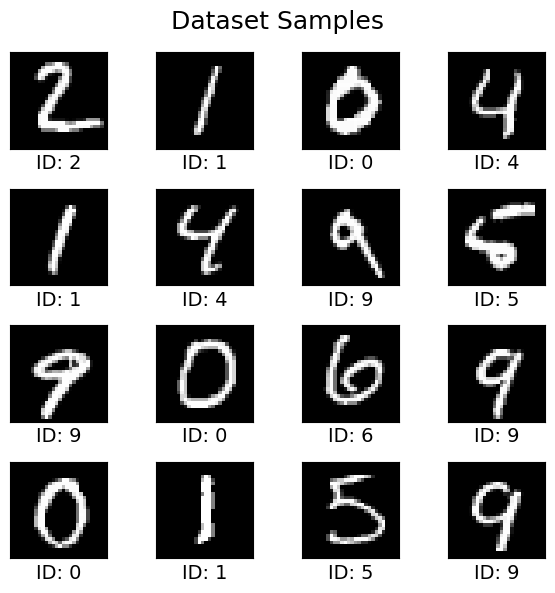

In [ ]:
train_loader, valid_loader = get_data(
    resize_to=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
    batch_size=TrainingConfig.BATCH_SIZE,
    data_root=DatasetConfig.DATA_ROOT,
)

visualize_samples(valid_loader)

## 5 Training and Evaluation Helper functions

In the previous unit, we defined two helper functions, `train_one_epoch(...)` and `evaluate(...)`, to facilitate the training and evaluation of the model. Several significant changes have been implemented, which are summarized as follows:

1. Instead of utilizing a progress bar exclusively for the main training loop, we have now integrated it into both functions. This enhancement allows us to monitor the progress during the processing of the dataloader. The progress bar will provide regular updates on the running loss and accuracy of the model.

2. We have introduced a new package called `TorchMetrics` <a href="https://torchmetrics.readthedocs.io/" target="_blank">[documentation]</a> to handle the recording and calculation of loss and accuracy for each data batch. To compute the mean loss of the epoch, we employ the `MeanMetric` class, which tracks the loss on each data batch and returns the running mean. Similarly, for calculating batch accuracy and running mean accuracy, we utilize the `MulticlassAccuracy` class.

### 5.1 Training Function

In [ ]:
def train_one_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes: int,
    epoch_idx: int,
    total_epochs: int,
):
    # Set model to training mode.
    model.train()

    # Torchmetrics classes used to record and calulate loss and accuracy
    loss_record = MeanMetric()
    acc_record  = MulticlassAccuracy(num_classes=num_classes, average="micro")

    loader_len = len(loader)

    with tqdm(total=loader_len, ncols=122, ascii=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch_idx}/{total_epochs}")

        for data, target in loader:
            tq.update(1)

            # Send data and target to GPU device if available.
            data   = data.to(device)
            target = target.to(device)

            # Reset parameters gradient to zero.
            optimizer.zero_grad()

            # Perform forward pass through the model.
            logits = model(data)

            # Calculate Cross-entropy loss.
            loss = F.cross_entropy(logits, target)

            # Find gradients w.r.t training parameters.
            loss.backward()

            # Update parameters using gradients.
            optimizer.step()

            # Record loss.
            loss_record.update(loss.detach().cpu(), weight=data.shape[0])

            # Get the index of node with max score.
            pred = torch.argmax(logits, dim=1)

            # Calculate and record accuracy.
            acc_record.update(pred.cpu(), target.cpu())

            # Update progress bar description with running mean and accuracy values.
            tq.set_postfix_str(s=f"Loss: {loss_record.compute():.4f}, Acc: {acc_record.compute():.4f}")

    # Get final loss and accuracy.
    # The values are the same as the one displayed for the final iteration.
    epoch_loss = loss_record.compute()
    epoch_acc  = acc_record.compute()

    return epoch_loss.item(), epoch_acc.item()

### 5.2 Evaluation Function

In [ ]:
def evaluate(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes: int,
    epoch_idx: int,
    total_epochs: int,
    validation: bool = True
):

    # Set model to evaluation mode.
    model.eval()

    loss_record = MeanMetric()
    acc_record = MulticlassAccuracy(num_classes=num_classes, average="micro")

    loader_len = len(loader)

    with tqdm(total=loader_len, ncols=122, ascii=True) as tq:
        tq.set_description(f"{'Valid' if validation else 'Test'} :: Epoch: {epoch_idx}/{total_epochs}")

        for data, target in loader:
            tq.update(1)

            # Send data and target to GPU device if available.
            data     = data.to(device)
            target = target.to(device)

            with torch.no_grad():
                # Perform forward pass through the model.
                logits = model(data)

            # Calculate Cross-entropy loss.
            loss = F.cross_entropy(logits, target)

            # Record loss.
            loss_record.update(loss.cpu(), weight=data.shape[0])

            # Get the index of node with max score.
            pred = torch.argmax(logits, dim=1)

            # Calculate and record accuracy
            acc_record.update(pred.cpu(), target.cpu())

        eval_epoch_loss = loss_record.compute()
        eval_epoch_acc  = acc_record.compute()

        # Update progress bar description to display epoch log.
        tq.set_postfix_str(s=f"Loss: {eval_epoch_loss:.4f}, Acc: {eval_epoch_acc:.4f}")

    return eval_epoch_loss.item(), eval_epoch_acc.item()

## 6 Main function for Training

The `main(...)` function encompasses all the crucial components necessary for running experiments in a repetitive manner. Additionally, we will utilize the `livelossplot` package to automatically generate live matplotlib plots, enabling us to visualize the accuracy and loss of the model. This visualization approach proves to be more insightful than simply printing logs, as it aids in better understanding the training and evaluation processes.

Outlined below are the significant and recurring actions performed within the `main(...)` function:

1. Creation of dataloaders.
2. Initialization of variables to track the loss and accuracy per epoch.
3. Executing a training loop that will run for a predetermined number of epochs.
4. Within each epoch, invocation of the `train_one_epoch(...)` function and the `evaluate(...)` function.
5. Recording and plotting of the loss and accuracy per epoch.
6. Saving the best model based on the validation loss.

In [ ]:
def main(model, optimizer, device, pin_memory=False, ckpt_name="best_model"):

    # Intialize train and valid dataloaders.
    train_loader, valid_loader = get_data(
                resize_to = (DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
               batch_size = TrainingConfig.BATCH_SIZE,
                data_root = DatasetConfig.DATA_ROOT,
               pin_memory = pin_memory,
              num_workers = TrainingConfig.NUM_WORKERS,
    )

    # Accumulate train and valid epoch metrics.
    epoch_train_acc  = []
    epoch_valid_acc  = []
    epoch_train_loss = []
    epoch_valid_loss = []

    # Plot training and validation epoch logs.
    live_plot = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6, 2)), ExtremaPrinter()])

    # To save model with the best validation loss.
    best_valid_loss = float("inf")

    # # # Compile Model.
    # # Uncomment this line if you are using PyTorch 2.0.
    # # Sometimes compilation can also lead to error, do a test run with few epochs
    # # to ensure the code runs without any error. If it doesn't turn off compilation.
    # model = torch.compile(model)

    for epoch in range(TrainingConfig.NUM_EPOCHS):

        # Train for one epoch.
        train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, device, DatasetConfig.NUM_CLASSES, epoch+1, TrainingConfig.NUM_EPOCHS)

        # Perform validation run.
        valid_loss, valid_acc = evaluate(model, valid_loader, device, DatasetConfig.NUM_CLASSES, epoch+1, TrainingConfig.NUM_EPOCHS)

        # Save model checkpoint if validation loss improves.
        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss

            print("Model Improved. Saving...", end="")

            checkpoint_dict = {
                "opt": optimizer.state_dict(),
                "model": model.state_dict(),
            }

            torch.save(checkpoint_dict, f"{ckpt_name}.tar")
            del checkpoint_dict
            print("Done.\n")


        # Collect loss and accuracy
        epoch_train_loss.append(train_loss)
        epoch_valid_loss.append(valid_loss)
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)

        # Plot train and validation statistics.
        live_plot.update({
                    "loss": train_loss,
                "val_loss": valid_loss,
                "accuracy": train_acc,
            "val_accuracy": valid_acc,
        })

        live_plot.send()


    # Cleanup
    del model
    del optimizer
    del train_loader
    del valid_loader

    gc.collect()
    torch.cuda.empty_cache()

    return epoch_train_acc, epoch_train_loss, epoch_valid_acc, epoch_valid_loss

## 7 Model Architecture

### 7.1 Single Layer, Multiple Output Architecture

The network architecture shown below is similar to the  binary classification architecture shown above but with some important differences. The key differences are summarized below:

1. The input data is an image that is flattened and pre-processed. For MNIST digit image there will `784` input nodes.
2. We now have 10 neurons to represent the ten different classes (digits: 0 to 9), instead of a single neuron as with binary classification.
3. The unnormalized model outputs "logits" are directly passed to the loss function.
4. The loss function is now **Cross Entropy**.

Although the diagram looks quite a bit different from previous (single neuron) architectures, it is fundamentally very similar in terms of the processing that takes place during training and prediction.


<img src='https://opencv.org/wp-content/uploads/2023/05/c3_week3_MNIST_network.png' width=900 align='center'><br/>

### 7.2 Fully Connected (Dense) Layers

The neural network architectures have "fully connected" layers which are also referred to as "dense" or "linear" layers. This is very common, but as the number of inputs and neurons in each layer becomes larger, the number of trainable parameters grows significantly. The figure below shows two examples of fully connected layers. When depicting neural network architectures with fully connected layers, the connections are typically omitted with the understanding that 'dense' or 'fully connected' is assumed.

<img src='https://learnopencv.com/wp-content/uploads/2022/01/c4_02_dense_layers.png' width=700 align='center'>

When working with images, the number of parameters can become exceedingly large as the number of neurons and the number of layers in the network is increased. For example, it is not uncommon for state-of-the-art networks to contain millions of parameters. Larger networks hold the potential to exceed the performance of smaller networks, but that comes at the cost of much longer training times. In order to mitigate these issues, we will see that the data in the network is sometimes down-sampled at intermediate layers, which reduces the number of parameters.

One approach that is used to down-sample data in Convolutional Neural Networks (CNNs), which we'll see in upcoming sections, is called 'pooling.'


Increasing the number of parameters in a deep learning model can increase the risk of *overfitting*. Overfitting occurs when a model becomes too complex and starts to memorize the training data instead of learning general patterns that can be applied to new, unseen data.

When you increase the number of parameters in a deep learning model, it gives the model more capacity to fit the training data closely. This increased capacity allows the model to learn more intricate and complex relationships within the data, potentially capturing noise and random fluctuations present in the training set. As a result, the model may become overly specialized to the training data and perform poorly on new, unseen data.

A commonly used method to combat overfitting is called "dropout", which is a stochastic regularization technique that randomly dropping a percentage of neurons from the network during training. We will cover these topics in more detail later in the course.

### 7.3 Model Architecture Definition

In [ ]:
class SingleLayerPerceptron(nn.Module):
    def __init__(self, in_features=784, num_classes=10):
        super().__init__()

        self.in_features = 784
        self.num_classes = num_classes

        self.linear = nn.Sequential(

            nn.Flatten(), # To Flatten the `(B, 1, 28, 28)` shape input tensor to `(B, 784)` features.
                          # The `1x28x28` input image thus becomes a 1D array containing `784` features.

            # Single Linear layer mapping "in_features" nodes to "num_classes" nodes.
            nn.Linear(in_features=self.in_features, out_features=self.num_classes)
        )

    # Perform foward pass through the model.
    def forward(self,x):
        x = self.linear(x)
        return x

In [ ]:
# Initialize dummy model.
model = SingleLayerPerceptron(in_features=DatasetConfig.CHANNELS * DatasetConfig.HEIGHT * DatasetConfig.WIDTH,
                              num_classes=DatasetConfig.NUM_CLASSES)

# Printing model summary.
summary(model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
SingleLayerPerceptron                    [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 10]                   7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

### 7.4 Train The Model

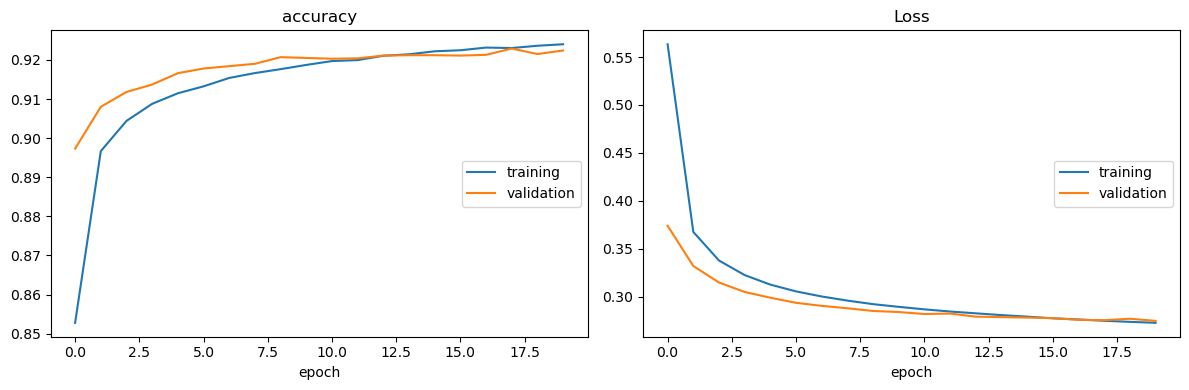

accuracy
	training         	 (min:    0.853, max:    0.924, cur:    0.924)
	validation       	 (min:    0.897, max:    0.923, cur:    0.922)
Loss
	training         	 (min:    0.273, max:    0.563, cur:    0.273)
	validation       	 (min:    0.275, max:    0.374, cur:    0.275)


In [ ]:
# Get available accelearation device.
DEVICE, GPU_AVAILABLE = get_default_device()

# Set Randomization seeds.
seed_everything(41)

# Initialize Model
model = SingleLayerPerceptron(in_features=DatasetConfig.CHANNELS * DatasetConfig.HEIGHT * DatasetConfig.WIDTH, num_classes=DatasetConfig.NUM_CLASSES)
model.to(DEVICE)

# Intiaize Optimizer.
optimizer = optim.SGD(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
)

# # Compile Model. Comment this line if there are any problems during training.
# compiled_model = torch.compile(model)

train_acc_exp1, train_loss_exp1, valid_acc_exp1, valid_loss_exp1 = main(model, optimizer, DEVICE, pin_memory=GPU_AVAILABLE, ckpt_name="single_layer_perceptron")

## 8 Multi Layer Perceptron

In the previous section we shown how to use a single layer perceptron for training. In this section, we will try to improve the results by implementing a Multi Layer Perceptron (MLP).

We define the `MLP` class. It has 2 hidden layers with 512 units. Also note that the input layer has `1*28x28` nodes which is the size of the flattened data. Given below is the schematic diagram of the network.

<img src="https://www.learnopencv.com/wp-content/uploads/2017/10/mlp-mnist-schematic.jpg" width=700>

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features=748, num_classes=10):
        super().__init__()

        self.in_features = in_features
        self.num_clasees = num_classes

        # Build model using Sequential container
        self.classifier = nn.Sequential(
            # Flatten the input tensor.
            nn.Flatten(),

            # First hidden layer.
            nn.Linear(in_features=self.in_features, out_features=512),
            # Add ReLU activation
            nn.ReLU(),

            # Second hidden layer.
            nn.Linear(in_features=512, out_features=512),
            # Add ReLU activation
            nn.ReLU(),

            # Add Output layer
            nn.Linear(in_features=512, out_features=self.num_clasees),
        )

    # Forward Pass.
    def forward(self, x):
        x = self.classifier(x)
        return x

In [ ]:
# Initialize dummy model.
model = MLP(in_features=DatasetConfig.CHANNELS * DatasetConfig.HEIGHT * DatasetConfig.WIDTH,
            num_classes=DatasetConfig.NUM_CLASSES
           )

# Printing model summary.
summary(model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 512]                  401,920
│    └─ReLU: 2-3                         [1, 512]                  --
│    └─Linear: 2-4                       [1, 512]                  262,656
│    └─ReLU: 2-5                         [1, 512]                  --
│    └─Linear: 2-6                       [1, 10]                   5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
Total mult-adds (M): 0.67
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.68
Estimated Total Size (MB): 2.69

### 8.1 Train The Model

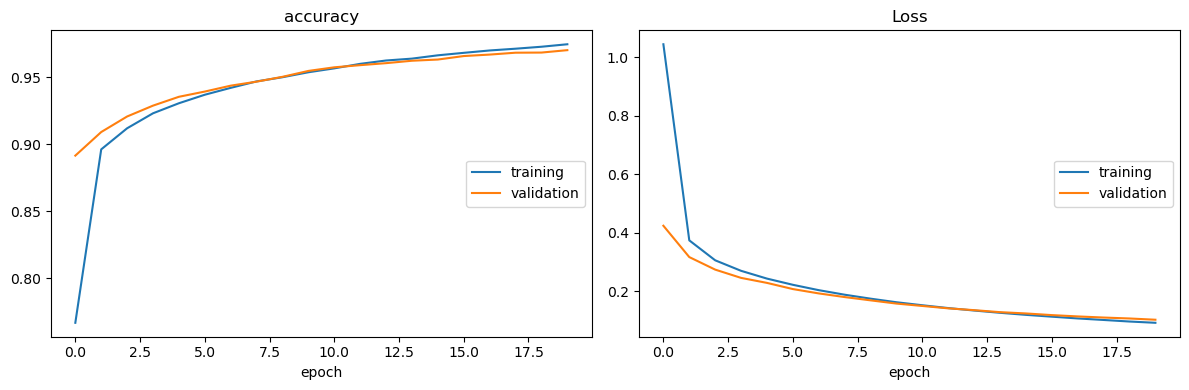

accuracy
	training         	 (min:    0.767, max:    0.975, cur:    0.975)
	validation       	 (min:    0.891, max:    0.970, cur:    0.970)
Loss
	training         	 (min:    0.092, max:    1.044, cur:    0.092)
	validation       	 (min:    0.102, max:    0.424, cur:    0.102)


In [ ]:
# Get available accelearation device.
DEVICE, GPU_AVAILABLE = get_default_device()

# Set Randomization seeds.
seed_everything(41)

# Initialize Model
model = MLP(in_features=DatasetConfig.CHANNELS * DatasetConfig.HEIGHT * DatasetConfig.WIDTH,
            num_classes=DatasetConfig.NUM_CLASSES
           )
model.to(DEVICE)

# Intiaize Optimizer.
optimizer = optim.SGD(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
)

# # Compile Model. Comment this line if there are any problems during training.
# compiled_model = torch.compile(model)

train_acc_exp2, train_loss_exp2, valid_acc_exp2, valid_loss_exp2 = main(model, optimizer, DEVICE, pin_memory=GPU_AVAILABLE, ckpt_name="multi_layer_perceptron")

## 9 Model Evaluation

### 9.1 Load Trained Model

In [ ]:
DEVICE, _ = get_default_device()

# Loading best MLP model.
mlp_model = MLP(in_features=DatasetConfig.CHANNELS * DatasetConfig.HEIGHT * DatasetConfig.WIDTH,
                num_classes=DatasetConfig.NUM_CLASSES
               )

mlp_model.to(DEVICE)

# # Compile mlp_model if model was compiled during training.
# mlp_model = torch.compile(mlp_model)
mlp_model.load_state_dict(torch.load("multi_layer_perceptron.tar", map_location=DEVICE)['model'])

mlp_model.eval();

### 9.2 Make Predictions on a Sample Test Image

We can now predict the results for all the test images. We select a specific index from the test set and print out the predicted scores for each class. You can experiment with the code below by setting the test index to various values and see how the highest score is usually associated with the correct value indicated by the ground truth.

In [ ]:
# Intialize valid dataloader.
_, valid_loader = get_data(
        resize_to = (DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
       batch_size = TrainingConfig.BATCH_SIZE,
        data_root = DatasetConfig.DATA_ROOT,
)

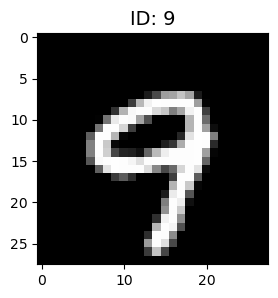

In [ ]:
import random

batch_images, batch_targets = next(iter(valid_loader))

denorm_batch_images = denormalize(batch_images,
                                  mean=DatasetConfig.MEAN, std=DatasetConfig.STD
                                 )

rand_idx = random.choice(range(len(denorm_batch_images)))

plt.figure(figsize=(3, 3))
plt.imshow(denorm_batch_images[rand_idx].squeeze(), cmap="gray")
plt.title(f"ID: {(int(batch_targets[rand_idx]))}", fontsize=14)
plt.show()
plt.close();

In [ ]:
with torch.no_grad():
    batch_outputs = mlp_model(batch_images.to(DEVICE))

prob_score_batch = batch_outputs.softmax(dim=1).cpu()

prob_score_test_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_test_image.argmax()

print('Predictions for each class on test image:\n')

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx==pred_cls_id:
        print(f"{BOLD}Digit: {idx}, Probability: {cls_prob:.3f}{END}")
    else:
        print(f"Digit: {idx}, Probability: {cls_prob:.3f}")

Predictions for each class on test image:

Digit: 0, Probability: 0.038
Digit: 1, Probability: 0.005
Digit: 2, Probability: 0.021
Digit: 3, Probability: 0.056
Digit: 4, Probability: 0.097
Digit: 5, Probability: 0.043
Digit: 6, Probability: 0.007
Digit: 7, Probability: 0.095
Digit: 8, Probability: 0.055
Digit: 9, Probability: 0.583


### 9.3 Compute Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of data for which the true values are known. It's a specific table layout that allows visualization of the performance of the algorithm.

A confusion matrix is of the form:

| - | Predicted: No | Predicted: Yes |
|---|--------------|----------------|
| Actual: No | True Negatives (TN) | False Positives (FP) |
| Actual: Yes | False Negatives (FN) | True Positives (TP) |

Where:
- True Positives (TP): The cases in which the model predicted yes (positive), and the actual was also yes (positive).
- True Negatives (TN): The cases in which the model predicted no (negative), and the actual was also no (negative).
- False Positives (FP): The cases in which the model predicted yes, but the actual was no.
- False Negatives (FN): The cases in which the model predicted no, but the actual was yes.

The confusion matrix is extremely useful for measuring Recall, Precision, Specificity, Accuracy and most importantly AUC-ROC Curve.

**Why it is used:**

1. **Balanced dataset**: When the classification dataset is balanced, accuracy can be used to measure the performance. However, more details such as precision, recall, and F1-score are preferable to understand the behavior of the model, and all these details are present in the confusion matrix.

2. **Imbalanced dataset**: When the classification dataset is imbalanced, accuracy is not a good measure to estimate the performance of the model. In such case, a confusion matrix is a comprehensive matrix that gives a breakdown of all the class-wise details to understand the model's performance.

3. **Multi-class problems**: In multi-class problems, the number of true and false positives, and true and false negatives can be calculated for each class. So, confusion matrix helps to understand the model performance for each individual class.

4. **Cost-sensitive problems**: There are problems where the cost of misclassification of the classes are different. In this case, the confusion matrix can be useful to calculate the total cost of the misclassification by the model.

5. **Identifying Bias**: The confusion matrix is also useful to see if the model is biased towards a particular class. This is especially true in an imbalanced dataset where a model could have a bias towards the majority class.

So, in all the above scenarios, confusion matrix plays a crucial role to understand the model's performance.

We need to collect validation ground truth labels and obtain the predictions of the samples across the entire validation data to pass it through the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html" target="_blank">confusion matrix</a> function.

The `prediction_batch` function takes in the trained model and the image batch and returns the class index having the highest logits.

In [ ]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in valid_loader:
    with torch.no_grad():
        batch_outputs = mlp_model(image_batch.to(DEVICE))

    batch_pred_cls_id = batch_outputs.argmax(dim=1).cpu()

    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)


val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

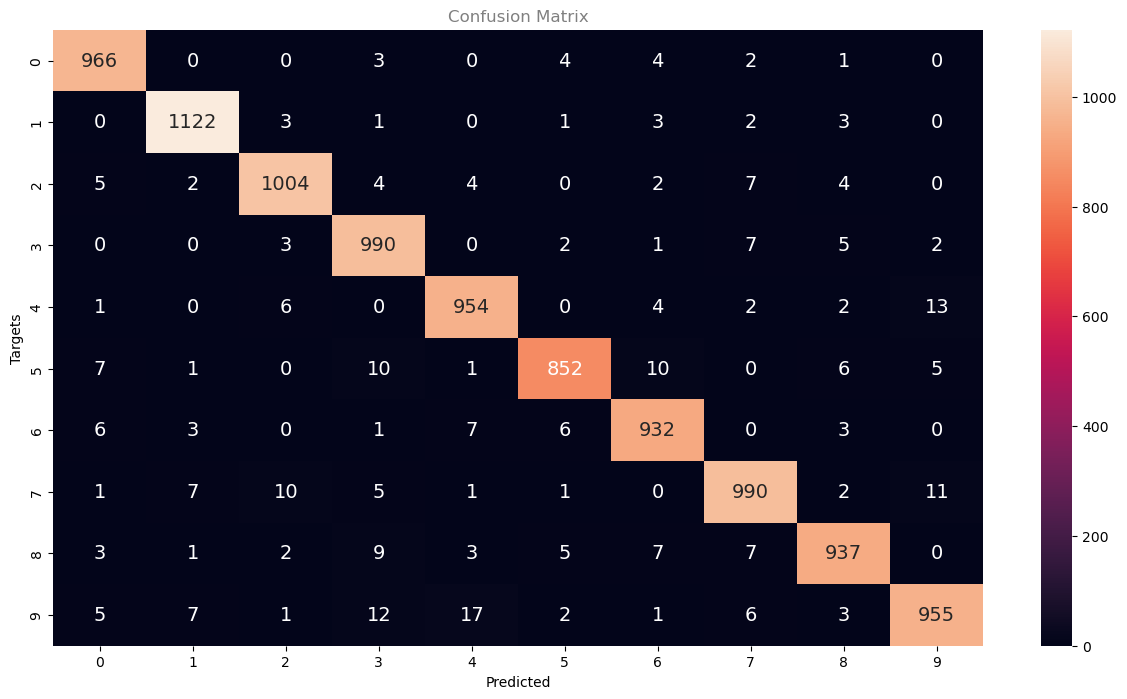

In [ ]:
cm = confusion_matrix(y_true=val_target_labels, y_pred=val_predicted_labels)

plt.figure(figsize=[15, 8])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title("Confusion Matrix", color="gray")
plt.show()

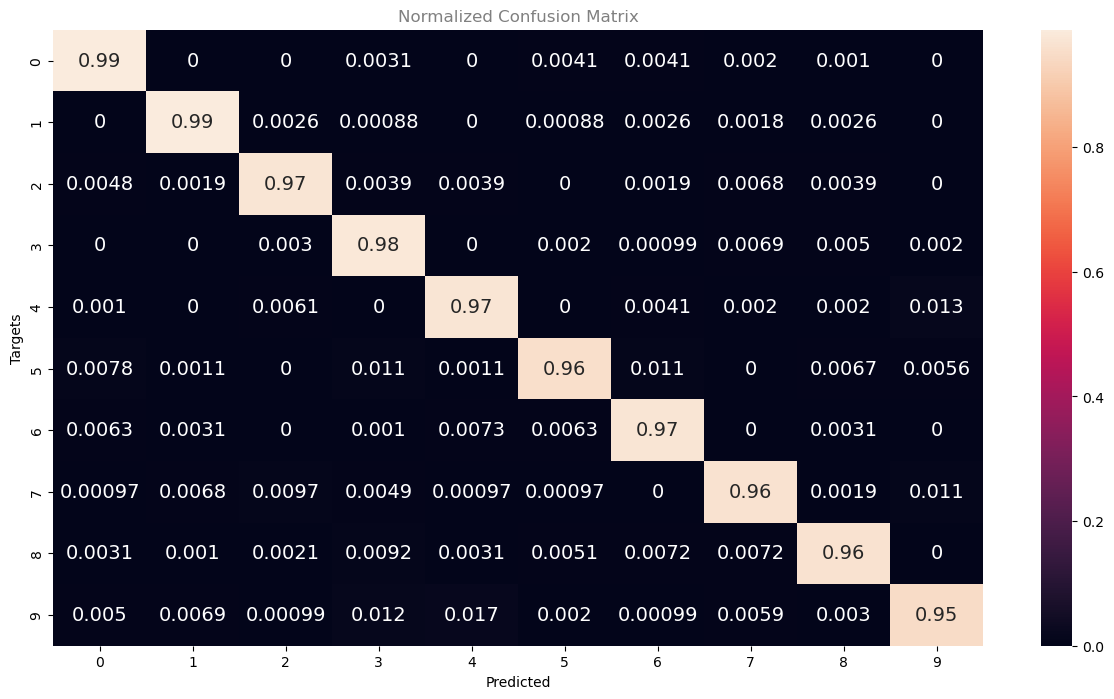

In [ ]:
cm_norm = confusion_matrix(y_true=val_target_labels, y_pred=val_predicted_labels, normalize="true")

plt.figure(figsize=[15, 8])
sn.heatmap(cm_norm, annot=True, annot_kws={"size": 14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title("Normalized Confusion Matrix", color="gray")
plt.show()

## 10 Conclusion

In this notebook, we introduced multinomial classification, which is an extension to binary classification that uses the softmax activation function. We also introduced one (simple) approach for how to preprocess image data for use in a neural network. In the next module we will learn about Convolutional Neural Networks (CNNs) that are specifically designed to process image data. The following link contains a really nice interactive web-based animation of several well known CNN architectures, which is a great place to start getting familiar with them.

https://tensorspace.org/html/playground/lenet.html

## References

1. <a href="https://blog.feedly.com/tricks-of-the-trade-logsumexp/" target="_blank">Tricks of the Trade: LogSumExp</a>
2. <a href="https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/" target="_blank">The Log-Sum-Exp Trick
</a>
